<a href="https://colab.research.google.com/github/ChumakovTim2/Grafik-in-PYGAME/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%A2%D0%B8%D0%BC%D0%BE%D1%84%D0%B5%D0%B9_%D0%A7%D1%83%D0%BC%D0%B0%D0%BA%D0%BE%D0%B2_15_%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%BF%D0%B8%D0%BD%D0%B3%D0%B2%D0%B8%D0%BD%D0%BE%D0%B2%22_2_0%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Кластеризация для набора данных о пингвинах со станции Палмера

## Задание 
Проведите анализ данных, используя этот блокнот. Ответьте на 6 вопросов, приведенных в конце блокнота, добавьте, где нужно, свой код.

**Цель:** выполнить кластеризацию для набора данных про пингвинов.
При этом мы НЕ будем использовать информацию о видах пингвинов (это набор данных является частью библиотеки **seaborn**) из данных (столбец - species	). 
Она нам только поможет сравнить "наш" способ кластеризации и классический.

Шаг 1. **Подготовка данных.** Загрузить и предподготовить данные (убрать "лишние" столбцы и строки, маштабировать данные). Про масшабирование подробнее поговорим на следуюещем уроке.

Шаг 2. **Выбор количества кластеров (k):**

1.  **Метод локтя (elbow method)**. Построим график зависимости качества кластериации k-means от количества кластеров и выберем 1-2 варианта оптимального количества кластеров.
2. **Clustergram**. Используя библиотеку Clustergram (подробнее можно прочитать здесь - https://habr.com/ru/company/skillfactory/blog/559388/) для kNN визуализируем разбиение данных на кластеры при разных k (количество кластеров). **Важно!** Поддерживает не все методы кластеризации.

Шаг 3. **Кластеризация и анализ результата.** Кластеризация с выбранными k и сравнение кластеров с видами пингвинов.

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns   #  библиотека для создания статистических графиков
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale  # для масштабирования признаков

## Шаг 1. Подготовка данных.

Состав учебного набора данных (dataset) о пингивинах из библиотеки seaborn:  
1. species -вид: Adelie - пингвины Адели, Chinstrap - антарктический пингвин, Gentoo - субарктический пингвин
2. island - Остров (не используем)
3. bill_length_mm - длина клюва
4. bill_depth_mm - глубина/толщина клюва
5. flipper_length_mm - крыла
6. body_mass_g - масса тема
7. sex - самцы / самки

Загрузим набор данных и посмотрим на первые 5 строк, на распределение по группам и на статистические данные для числовых значений (минимум, максимум, медиану, дисперсию и т.п.)

In [ ]:
penguins = sns.load_dataset("penguins")
penguins.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Посмотрим, как распределены данные по виду и полу пингвинов. В дальнейшем нам  это может пригодиться.

In [ ]:
penguins.groupby(["species", "sex"]).agg({"bill_length_mm": "count"})

bill_length_mm
species   sex                   
Adelie    Female              73
          Male                73
Chinstrap Female              34
          Male                34
Gentoo    Female              58
          Male                61

Посмотрим на статистики для числовых признаков

In [ ]:
penguins.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Видим, что диапазоны распределения значений признаков сильно отличаются по значениям. Поэтому желательно привести числовые значения признаков к единой шкале (ниже используем метод scale).

Визуализируем данные про пингвинам. Отобразим распределение видов, выбирая попарно признаки в качестве осей. Для этого используем функцию *pairplot* из библиотеки seaborn.

Text(0.5, 1.01, 'Пингвины со станции Пальмера (Palmer penguins)')

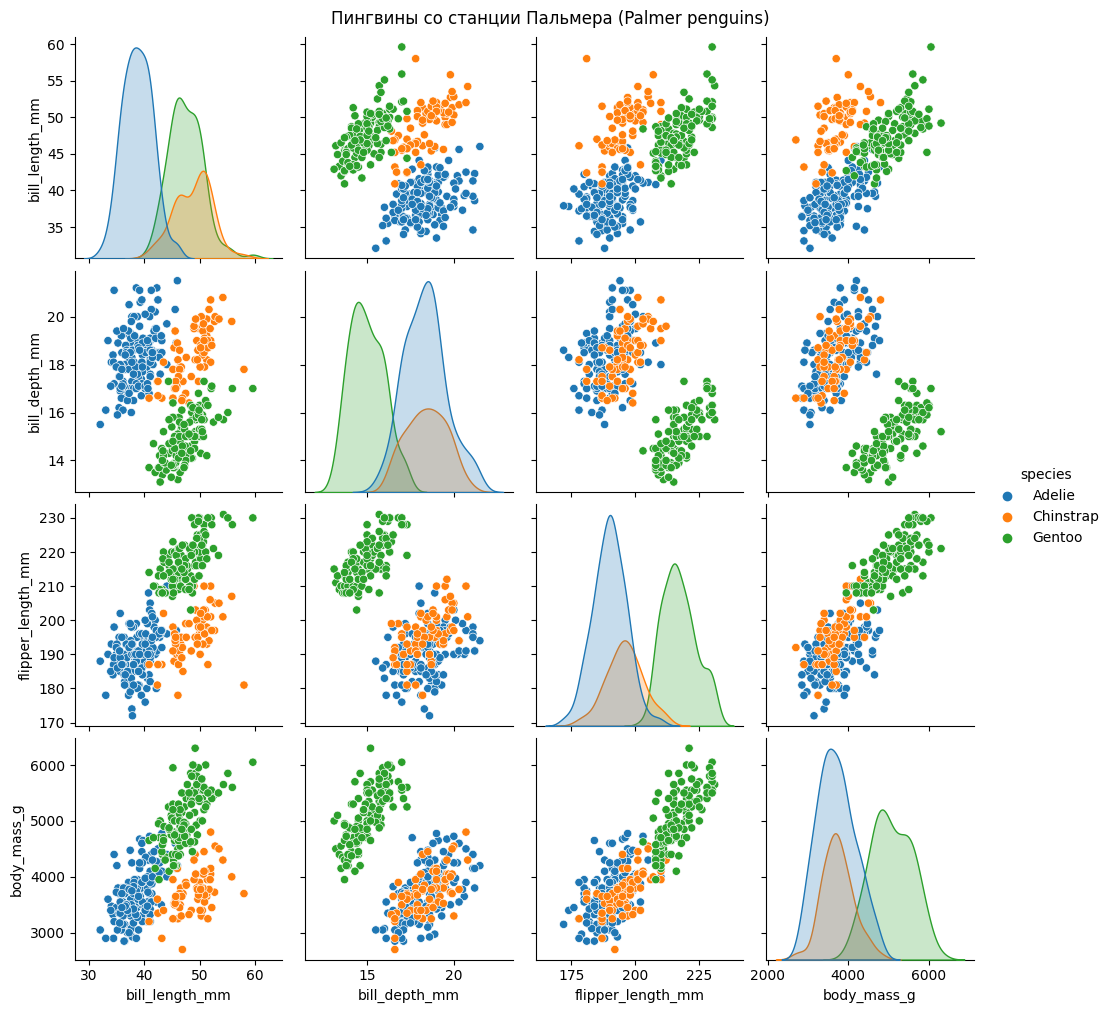

In [ ]:
g = sns.pairplot(penguins, hue="species")
g.fig.suptitle("Пингвины со станции Пальмера (Palmer penguins)", y=1.01)

По визуализации мы видим перекрытия между видами пингвинов. Скорее всего, идентифицировать их будет сложно. Кроме того, мы знаем, что существует три кластера, но это не означает, что метод k-means способен их различать. 

По данным мы ожидаем, что собенно сложно будет отличить пингвинов Адели от антарктических пингвинов (Chinstrap).

Далее,
1.  Удалим строки, если в них есть незаполненные значения признаков (NaN)
2.    Оставим только столбцы с признаками, удалив все остальные столбцы, включая "*species*", который содержит информацию о виде пингвина.  
3.   Масштабируем признаки, используя функцию *scale* из sklearn.preprocessing. Зачем это нужно? Т.к. диапазон изменения значений у признаков сильно оличается (сравните, например, какие значения принимает "длина клюва, в мм" и "масса тела, в г"). По сути мы подбираем такие единицы измерения для каждого признака, чтоб все значения были в одном и том же диапазоне. 

In [ ]:
penguins = penguins.dropna()
X = scale(penguins.drop(columns=['species', 'island', 'sex']))

Теперь данные подготовлены к дальнейшему анализу (кластеризации).

## Выбор k для метода к-средних (k-means)

### Метод локтя

Метод локтя (elbow method) - это метод подбора оптимального кол-ва кластеров.

В чем идея? 

Кластеризация проводится с разным числом кластеров, вычсляется сумма квадратов расстояний от объектов до центра их кластера. Если сумма большая, то объекты в целом далеки от центров, если очень маленькое, то кластеры кучные или просто центров так много, что в целом везде есть маленькие близкие группы.

Выбирается число, где расстояние до центра кластера перестает существенно меняться (***кластеры достаточно кучные, но не слишком мелкие***).

На графике это место “перелома”, где кривая переходит к пологому участку. Этот ***изгиб похож на изгиб руки в локте***, поэтому этот метод так называется.

Метрика inertia_ - это сумма квадратов расстояний от объекта до центра кластера и характеризует качество кластеризации. На графике отобразим квадратный корень из inertia. Чем меньше это значение, тем лучше качество кластеризации по этой метрике.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

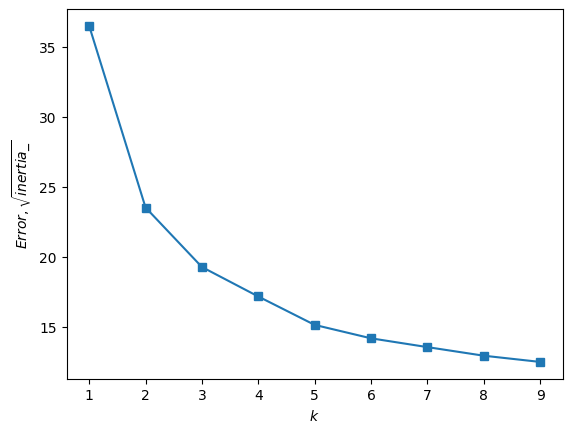

In [ ]:
from sklearn.cluster import KMeans # подключаем KMeans кластеризацию

inertia = [] # здесь будем накапливать ошибки
for k in range(1, 10): # 
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X) # создаем и обучаем кластеризатор с заданным числом кластеров
    inertia.append(np.sqrt(kmeans.inertia_)) # смотрим на ошибку, добавляем ее в историю

plt.plot(range(1, 10), inertia, marker='s'); # строим график ошибки
plt.xlabel('$k$') #
plt.ylabel('$Error, \sqrt{inertia\_}$'); #

#### Вопрос 1.
Определите по графику место "перелома", переход к плоскому участку ("изгиб локтя").  
Какое количество кластеров (по графику выше) кажется наиболее удачным выбором? Укажиет два наиболее подходящих значения.

**Ваш ответ:** точка 2 - место "перелома", количество кластеров = 3

### Кластерограммой (Clustergram)

Используя библиотеку **Clustergram** (подробнее можно прочитать здесь - https://habr.com/ru/company/skillfactory/blog/559388/)  визуализируем разбиение данных на кластеры при разных k (количество кластеров) для метода k-means. 

**Важно!** Поддерживает не все методы кластеризации. 

Установим библиотеку clustergram в облаке colab

In [ ]:
!pip install clustergram

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Чтобы получить стабильный результат, мы можем запустить кластерную программу с 1000 инициализаций ( *n_init*),  для количества кластеров (*k_range*) от 1 до 9 (вкл.). 


K=1 skipped. Mean computed from data directly.
K=2 fitted in 10.922667980194092 seconds.
K=3 fitted in 16.74171781539917 seconds.
K=4 fitted in 1.697664499282837 seconds.
K=5 fitted in 2.102405071258545 seconds.
K=6 fitted in 2.4254329204559326 seconds.
K=7 fitted in 2.7979655265808105 seconds.
K=8 fitted in 5.014594316482544 seconds.
K=9 fitted in 3.330644130706787 seconds.


Text(0.5, 1.0, 'K-Means (scikit-learn)')

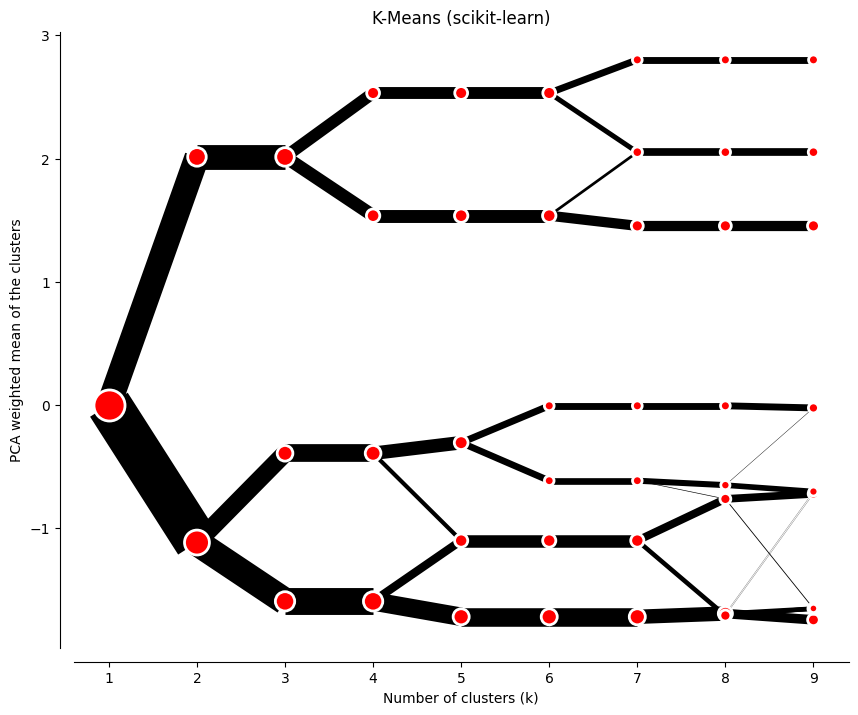

In [ ]:
from clustergram import Clustergram
cgram = Clustergram(k_range=range(1, 10), n_init=1000, method="kmeans")
cgram.fit(X)

ax = cgram.plot(
    figsize=(10, 8),
)
ax.yaxis.grid(False)
sns.despine(offset=10)
ax.set_title("K-Means (scikit-learn)")

На оси x мы видим количество кластеров. Точки представляют собой центр каждого кластера (по умолчанию). Линии, соединяющие точки, и их толщина представляют  наблюдения (строки набора данных), перемещающиеся между кластерами при изменении (увеличении) их количества. Поэтому мы можем увидеть по клестерограмме, когда новые кластеры образуются как расщепление одного существующего кластера и когда они образуются на основе наблюдений из двух кластеров (чем-то похоже на визуализацию дерева решений).

Мы ищем разделение, т. е. отвечаем на вопрос, принёс ли дополнительный кластер какое-либо значимое разделение? Идеального случая не существует. В конечном счёте нам необходимо принять решение об оптимальном количестве кластеров. Clustergam даёт нам дополнительные сведения о том, что происходит между различными вариантами, как они расходятся. По ней, также можно сказать, что пингвины Палмера могут оказаться сложными набором данных для кластеризации с помощью k-средних. Кластерограмма не даёт простого ответа, но она даёт нам лучшее понимание, а от нас зависит, как мы её [кластерограмму] интерпретируем.

#### Вопрос 2.
Какие значения k (количество центров искомых кластеров) по этой кластерограмме стОит (лучше) использовать для кластериазации метом k-means?

**Ваш ответ**:k3 и k4

## а) Кластеризация и анализ результата для одно из значений $k$

Выполните кластеризацию методм k-средник, используя одно из значений $k$, которое вы определили мыше (методом локтя или кластерограммой) 

In [ ]:
model1 = KMeans(n_clusters = 3, random_state=1)
model1.fit(X)
model1.inertia_**0.5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


19.255288715402504

Посмотрим метки кластеров, воспользовавшись функцией *predict* (20 шт). Они принимают значения от $0$ до $k-1$ 

Важно! Для метода k-средних *predict* возвращает номера кластеров для наборов (строк данных), на которых он "тренировался" (учился без учителя) и не для тествого набора. Так как тренировочного набора у кластеризации нет.

In [ ]:
clusters = model1.predict(X)
clusters[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0],
      dtype=int32)

Посмотрим, какие виды (*species*) пингвинов в какие кластеры попали (похожа ли логика нашего разбиения на кластеры с видами из исходного набора?).

Используем функцию, в которой:
1.   на пересечении строки **с видом** пингвина ($k$) и номера определенного вашей программой кластера ($m$) показыавет количество строк анализируемого набора, которые относятся к виду $k$ и были моделью кластеризации отнесены к кластеру $m$.
2.   на пересечении строки **с видом и полом** пингвина ($k$) и и номера определенного вашей программой кластера ($m$) показыавет количество строк анализируемого набора, которые относятся к виду и полу $k$ и были моделью кластеризации отнесены к кластеру $m$.

In [ ]:
def clusters_stats(clusters):
    
    # делаем копию датасета и сохраняем метки кластеров туда
    data_with_labels = penguins.copy()
    data_with_labels["cluster"] = clusters
    
    # смотрим сочетания меток видов и кластеров
    data_with_labels["i"] = 1
    print(data_with_labels.pivot_table(index="species", columns="cluster", values="i", aggfunc="sum").fillna("---"))
    print("-" * 50)
    
    # смотрим сочетания меток видов + гендер и кластеров
    print(data_with_labels.pivot_table(index=["species", "sex"], columns="cluster", values="i", aggfunc="sum").fillna("---"))

Применим созданную функцию и выведем две таблицы, по которым будем анализировать качество выполненной кластеризации.

In [ ]:
clusters_stats(clusters)

cluster        0      1     2
species                      
Adelie     124.0    ---  22.0
Chinstrap    5.0    ---  63.0
Gentoo       ---  119.0   ---
--------------------------------------------------
cluster              0     1     2
species   sex                     
Adelie    Female  73.0   ---   ---
          Male    51.0   ---  22.0
Chinstrap Female   5.0   ---  29.0
          Male     ---   ---  34.0
Gentoo    Female   ---  58.0   ---
          Male     ---  61.0   ---


### Вопрос 3 (по таблице вид <-> кластер).

1.   Какой из видов пингвинов соответствует ровно одному кластеру? Какой номер у этого кластера? 

Ответ: 1) Gentoo; 2) 1 claster

2.  Укажите **один** вид пингвинов, наблюдения (строки данных) для которых модель отнесла к разным кластерам? Какой из кластеров больше "похож" на этот вид?

**Ваш ответ:** Adelie: 0, 2 .  Больше всего этот вид похож на кластер 0.

### Вопрос 4 (по таблице вид, пол <-> кластер).

1.   Приведите пример одно вида пингвинов, для которого есть особи мужского и женского пола, которые модель к-средник отнесла к разным кластерам. Подкрепите свой ответ цифрами из таблицы. 

**Ваш ответ:**  <Adelie, Female  73.0   ---   ---,
                         Male    51.0   ---  22.0 >.

2.  Предложите гипотезу, из-за чего у модели возникли проблемы с кластеризацией данных о пингвинах? Что могло бы помочь сделать модель более однозначной?

**Ваш ответ:** <ваша гипотеза и предложения по улучшению, код новой модели писать не нужно>.

## б) Кластеризация и анализ результата для еще одного значения $k$

Выберите другое значение $k$ и проведите анализ, аналогичный проведенному в предыдущем разделе.

In [ ]:
# продублируйте сюда код для создания и обучения модели k-средних с еще одним значением k
# <код аналогичный приведенному выше, но с другим значением k>
model1 = KMeans(n_clusters = 6, random_state=1)
model1.fit(X)
model1.inertia_**0.5
# model2 = 6 

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


14.156467866350134

In [ ]:
clusters = model1.predict(X)
clusters[:20]

array([0, 0, 0, 0, 4, 0, 4, 0, 4, 4, 0, 4, 4, 0, 4, 0, 0, 4, 0, 0],
      dtype=int32)

In [ ]:
def clusters_stats(clusters):
    
    # делаем копию датасета и сохраняем метки кластеров туда
    data_with_labels = penguins.copy()
    data_with_labels["cluster"] = clusters
    
    # смотрим сочетания меток видов и кластеров
    data_with_labels["i"] = 1
    print(data_with_labels.pivot_table(index="species", columns="cluster", values="i", aggfunc="sum").fillna("---"))
    print("-" * 50)
    
    # смотрим сочетания меток видов + гендер и кластеров
    print(data_with_labels.pivot_table(index=["species", "sex"], columns="cluster", values="i", aggfunc="sum").fillna("---"))

In [ ]:
clusters_stats(clusters)

cluster       0     1     2     3     4     5
species                                      
Adelie     84.0   ---   ---   ---  60.0   2.0
Chinstrap   5.0   ---  33.0   ---   ---  30.0
Gentoo      ---  54.0   ---  65.0   ---   ---
--------------------------------------------------
cluster              0     1     2     3     4     5
species   sex                                       
Adelie    Female  70.0   ---   ---   ---   3.0   ---
          Male    14.0   ---   ---   ---  57.0   2.0
Chinstrap Female   5.0   ---   3.0   ---   ---  26.0
          Male     ---   ---  30.0   ---   ---   4.0
Gentoo    Female   ---   2.0   ---  56.0   ---   ---
          Male     ---  52.0   ---   9.0   ---   ---


In [ ]:
# предскажите разбиение на кластеры с созданной и обученной моделью
# выведите таблицы 1)   вид <-> кластер и 2) вид, пол <-> кластер , как это было сделано выше
# можно переиспользовать функцию, которая уже была определена выше.




### Вопрос 5 (по таблице вид <-> кластер).

1.   Какой из видов пингвинов соответствует ровно одному кластеру? Какой номер у этого кластера? 

**Ваш ответ:** таких пар нет.

2.  Укажите **один** вид пингвинов, наблюдения (строки данных) для которых модель отнесла к разным кластерам? Какой из кластеров больше "похож" на этот вид?

**Ваш ответ:** <Chinstrap>: 0, 2, 5.  Больше всего этот вид похож на кластер <2>.

### Вопрос 6. (по таблице вид, пол <-> кластер).

1.   Приведите пример одно вида пингвинов, для которого есть особи мужского и женского пола, которые модель к-средник отнесла к разным кластерам. Подкрепите свой ответ цифрами из таблицы. 

**Ваш ответ:**  <Ваш ответ, с опорой на цифры из таблицы>.

2.  Предложите гипотезу, из-за чего у модели возникли проблемы с кластеризацией данных о пингвинах? Что могло бы помочь сделать модель более однозначной?

**Ваш ответ:** <ваша гипотеза и предложения по улучшению, код новой модели писать не нужно>.